# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler



# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [3]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64) 

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:
# TODO: Build and train your network

# define dataloader parameters
batch_size = 20
num_workers=0

# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
classes = list(cat_to_name.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

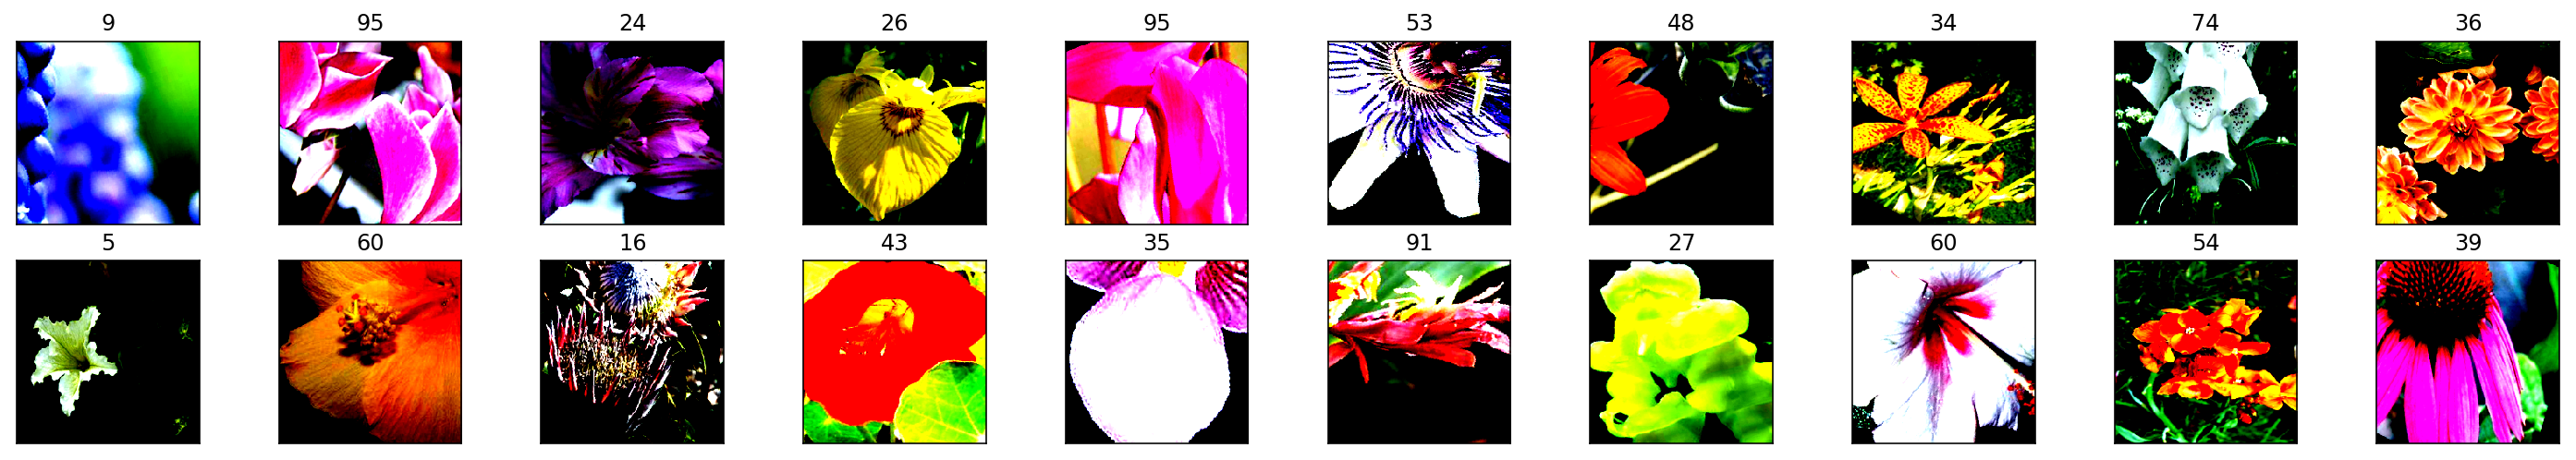

In [7]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [8]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [9]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

102


In [10]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [11]:
# number of epochs to train the model
n_epochs = 500

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 4.7091782331466678
Epoch 1, Batch 40 loss: 4.6177600145339968
Epoch 1, Batch 60 loss: 4.5490594148635868
Epoch 1, Batch 80 loss: 4.5092318058013916
Epoch 1, Batch 100 loss: 4.4257084131240845
Epoch 2, Batch 20 loss: 4.3710170269012449
Epoch 2, Batch 40 loss: 4.3410417318344114
Epoch 2, Batch 60 loss: 4.2935700416564941
Epoch 2, Batch 80 loss: 4.1941288948059086
Epoch 2, Batch 100 loss: 4.1559914469718935
Epoch 3, Batch 20 loss: 4.1679606556892397
Epoch 3, Batch 40 loss: 4.0644965291023256
Epoch 3, Batch 60 loss: 4.0491490840911863
Epoch 3, Batch 80 loss: 3.9804836153984069
Epoch 3, Batch 100 loss: 3.9426437854766845
Epoch 4, Batch 20 loss: 3.8655493021011353
Epoch 4, Batch 40 loss: 3.8548737764358521
Epoch 4, Batch 60 loss: 3.7532162308692931
Epoch 4, Batch 80 loss: 3.7136039972305297
Epoch 4, Batch 100 loss: 3.7500826954841613
Epoch 5, Batch 20 loss: 3.6448444962501525
Epoch 5, Batch 40 loss: 3.5572386145591737
Epoch 5, Batch 60 loss: 3.5514722943305967
Epoch 5

Epoch 38, Batch 60 loss: 0.9899667143821717
Epoch 38, Batch 80 loss: 0.9604935258626938
Epoch 38, Batch 100 loss: 1.0341279983520508
Epoch 39, Batch 20 loss: 1.0081387192010880
Epoch 39, Batch 40 loss: 0.9360386610031128
Epoch 39, Batch 60 loss: 0.9840630769729615
Epoch 39, Batch 80 loss: 0.9390728294849395
Epoch 39, Batch 100 loss: 0.9592731267213821
Epoch 40, Batch 20 loss: 0.9240175575017929
Epoch 40, Batch 40 loss: 0.9351900279521942
Epoch 40, Batch 60 loss: 0.8868282824754715
Epoch 40, Batch 80 loss: 0.9732095003128052
Epoch 40, Batch 100 loss: 0.9551848530769348
Epoch 41, Batch 20 loss: 0.9508939445018768
Epoch 41, Batch 40 loss: 0.9986403077840805
Epoch 41, Batch 60 loss: 0.9150111347436904
Epoch 41, Batch 80 loss: 0.9700010329484939
Epoch 41, Batch 100 loss: 0.9523843020200730
Epoch 42, Batch 20 loss: 0.9215171933174133
Epoch 42, Batch 40 loss: 0.9567619353532791
Epoch 42, Batch 60 loss: 0.8728346213698387
Epoch 42, Batch 80 loss: 0.9736496329307556
Epoch 42, Batch 100 loss: 0.

Epoch 75, Batch 80 loss: 0.7344082593917847
Epoch 75, Batch 100 loss: 0.7483999699354171
Epoch 76, Batch 20 loss: 0.7389732748270035
Epoch 76, Batch 40 loss: 0.6756712317466735
Epoch 76, Batch 60 loss: 0.7458337277173996
Epoch 76, Batch 80 loss: 0.6846317648887634
Epoch 76, Batch 100 loss: 0.7254399418830871
Epoch 77, Batch 20 loss: 0.6935855567455291
Epoch 77, Batch 40 loss: 0.7307862594723702
Epoch 77, Batch 60 loss: 0.7070290952920913
Epoch 77, Batch 80 loss: 0.7257875949144363
Epoch 77, Batch 100 loss: 0.6857852905988693
Epoch 78, Batch 20 loss: 0.6923276394605636
Epoch 78, Batch 40 loss: 0.7403252363204956
Epoch 78, Batch 60 loss: 0.7094763517379761
Epoch 78, Batch 80 loss: 0.7434133797883987
Epoch 78, Batch 100 loss: 0.6673249274492263
Epoch 79, Batch 20 loss: 0.7539290428161621
Epoch 79, Batch 40 loss: 0.6623234033584595
Epoch 79, Batch 60 loss: 0.7136025696992874
Epoch 79, Batch 80 loss: 0.6881155475974083
Epoch 79, Batch 100 loss: 0.7659777522087097
Epoch 80, Batch 20 loss: 0.

Epoch 112, Batch 60 loss: 0.5552744299173356
Epoch 112, Batch 80 loss: 0.6392094433307648
Epoch 112, Batch 100 loss: 0.6775867030024528
Epoch 113, Batch 20 loss: 0.5905005037784576
Epoch 113, Batch 40 loss: 0.5796075910329819
Epoch 113, Batch 60 loss: 0.6057603582739830
Epoch 113, Batch 80 loss: 0.5748975649476051
Epoch 113, Batch 100 loss: 0.6123422905802727
Epoch 114, Batch 20 loss: 0.5997410655021668
Epoch 114, Batch 40 loss: 0.6483849674463272
Epoch 114, Batch 60 loss: 0.5865027159452438
Epoch 114, Batch 80 loss: 0.6056755095720291
Epoch 114, Batch 100 loss: 0.6274124413728714
Epoch 115, Batch 20 loss: 0.5850861489772796
Epoch 115, Batch 40 loss: 0.5638616889715194
Epoch 115, Batch 60 loss: 0.5763319045305252
Epoch 115, Batch 80 loss: 0.5815021514892578
Epoch 115, Batch 100 loss: 0.5315330162644386
Epoch 116, Batch 20 loss: 0.6096624121069908
Epoch 116, Batch 40 loss: 0.6336456865072251
Epoch 116, Batch 60 loss: 0.6617958009243011
Epoch 116, Batch 80 loss: 0.5381284788250923
Epoch 

Epoch 148, Batch 100 loss: 0.5712466239929199
Epoch 149, Batch 20 loss: 0.5468677803874016
Epoch 149, Batch 40 loss: 0.5592408984899521
Epoch 149, Batch 60 loss: 0.4856489256024361
Epoch 149, Batch 80 loss: 0.5632817849516869
Epoch 149, Batch 100 loss: 0.4761632964015007
Epoch 150, Batch 20 loss: 0.5214578330516815
Epoch 150, Batch 40 loss: 0.5615511387586594
Epoch 150, Batch 60 loss: 0.5388510376214981
Epoch 150, Batch 80 loss: 0.5718313530087471
Epoch 150, Batch 100 loss: 0.5707234486937522
Epoch 151, Batch 20 loss: 0.5088195711374283
Epoch 151, Batch 40 loss: 0.5452947914600372
Epoch 151, Batch 60 loss: 0.5448695480823517
Epoch 151, Batch 80 loss: 0.5361203752458096
Epoch 151, Batch 100 loss: 0.4834914937615394
Epoch 152, Batch 20 loss: 0.5568880826234818
Epoch 152, Batch 40 loss: 0.5186328560113906
Epoch 152, Batch 60 loss: 0.5173334300518035
Epoch 152, Batch 80 loss: 0.5437648862600326
Epoch 152, Batch 100 loss: 0.5613420590758323
Epoch 153, Batch 20 loss: 0.5409967541694641
Epoch

Epoch 185, Batch 40 loss: 0.5119409024715423
Epoch 185, Batch 60 loss: 0.4984377682209015
Epoch 185, Batch 80 loss: 0.5212019205093383
Epoch 185, Batch 100 loss: 0.4645594358444214
Epoch 186, Batch 20 loss: 0.5061788886785508
Epoch 186, Batch 40 loss: 0.5083893865346909
Epoch 186, Batch 60 loss: 0.4809972003102302
Epoch 186, Batch 80 loss: 0.4580628991127014
Epoch 186, Batch 100 loss: 0.4709302693605423
Epoch 187, Batch 20 loss: 0.4701784797012806
Epoch 187, Batch 40 loss: 0.4956375613808632
Epoch 187, Batch 60 loss: 0.5043212518095970
Epoch 187, Batch 80 loss: 0.4507294043898583
Epoch 187, Batch 100 loss: 0.5164901033043862
Epoch 188, Batch 20 loss: 0.4930785462260246
Epoch 188, Batch 40 loss: 0.4878092080354691
Epoch 188, Batch 60 loss: 0.4947094932198525
Epoch 188, Batch 80 loss: 0.4302620187401772
Epoch 188, Batch 100 loss: 0.5124392941594124
Epoch 189, Batch 20 loss: 0.4624266728758812
Epoch 189, Batch 40 loss: 0.4852082476019859
Epoch 189, Batch 60 loss: 0.4718790069222450
Epoch 

Epoch 221, Batch 80 loss: 0.4923797279596329
Epoch 221, Batch 100 loss: 0.4982164293527603
Epoch 222, Batch 20 loss: 0.4509841211140156
Epoch 222, Batch 40 loss: 0.4626868814229965
Epoch 222, Batch 60 loss: 0.4567542195320130
Epoch 222, Batch 80 loss: 0.4477916464209556
Epoch 222, Batch 100 loss: 0.4122567862272263
Epoch 223, Batch 20 loss: 0.3965430505573749
Epoch 223, Batch 40 loss: 0.4281281098723412
Epoch 223, Batch 60 loss: 0.4281839683651924
Epoch 223, Batch 80 loss: 0.4517226532101631
Epoch 223, Batch 100 loss: 0.4557605274021626
Epoch 224, Batch 20 loss: 0.4621084988117218
Epoch 224, Batch 40 loss: 0.4232213973999023
Epoch 224, Batch 60 loss: 0.4185686506330967
Epoch 224, Batch 80 loss: 0.4211061544716358
Epoch 224, Batch 100 loss: 0.4364717170596123
Epoch 225, Batch 20 loss: 0.4489848017692566
Epoch 225, Batch 40 loss: 0.4592371910810470
Epoch 225, Batch 60 loss: 0.4242751307785511
Epoch 225, Batch 80 loss: 0.4314295142889023
Epoch 225, Batch 100 loss: 0.4598331466317177
Epoch

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
# TODO: Save the checkpoint 
# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch
# https://github.com/rajesh-iiith/AIPND-ImageClassifier/blob/master/predict.py

print("Our model: \n\n", vgg16, '\n')
print("The state dict keys: \n\n", vgg16.state_dict().keys())

model_name = 'img_classifier.net'

vgg16.class_to_idx = train_data.class_to_idx
checkpoint = {
    'class_to_idx': vgg16.class_to_idx,
    'classifier': vgg16.classifier,
    'optimizer': optimizer.state_dict(),
    'state_dict': vgg16.state_dict()}



with open(model_name, 'wb') as f:
    torch.save(checkpoint, 'checkpoint.pth')


Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [13]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
# https://github.com/rajesh-iiith/AIPND-ImageClassifier/blob/master/predict.py

def load_model(path):
    checkpoint = torch.load('checkpoint.pth')
    model = models.vgg16(pretrained=True)
    for param in model.parameters(): param.requires_grad = False
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

model = load_model('checkpoint.pth')

print(model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [14]:
from PIL import Image

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    
    # https://github.com/rajesh-iiith/AIPND-ImageClassifier/blob/master/predict.py
    #https://www.blog.pythonlibrary.org/2017/10/12/how-to-resize-a-photo-with-python/
    
    im = Image.open(image)
    size = 256,256
    resized_image = im.resize(size, Image.ANTIALIAS)
    # crop out the center 224x224 portion of the image
    
    # https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil/16648197
    width, height = resized_image.size   # Get dimensions
    
    new_width = 224
    new_height = 224
    
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    
    pil_image = resized_image.crop((left, top, right, bottom))   
    #pil_image = resized_image.crop((0, 0, 224, 224))
    # Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1
    np_image = np.array(pil_image)
    np_image = np_image/255.
    
    # the network expects the images to be normalized in a specific way. 
    chanel1 = np_image[:,:,0]
    chanel2 = np_image[:,:,1]
    chanel3 = np_image[:,:,2]
    
    chanel1 = (chanel1 - 0.485)/(0.229) 
    chanel2 = (chanel2 - 0.456)/(0.224)
    chanel3 = (chanel3 - 0.406)/(0.225)
        
    np_image[:,:,0] = chanel1
    np_image[:,:,1] = chanel2
    np_image[:,:,2] = chanel3
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image 
    # and Numpy array. You can reorder dimensions
    
    np_image = np.transpose(np_image, (2,0,1))
    
    return np_image


In [15]:
im = Image.open('fire-lilies-marilynne-bull.jpg')
size = 256,256
resized_image = im.resize(size, Image.ANTIALIAS)
# crop out the center 224x224 portion of the image
pil_image = resized_image.crop((0, 0, 224, 224))
# Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1
np_image = np.array(pil_image)
np_image = np_image/255.
chanel1 = np_image[:,:,0]
chanel1 = (chanel1 - 0.485)/(0.229)
chanel1 

array([[-0.88492165, -0.79929789, -0.67942461, ...,  2.07766076,
         1.95778748,  1.8379142 ],
       [-0.88492165, -0.73079887, -0.66229985, ...,  2.09478551,
         2.07766076,  2.00916174],
       [-0.8677969 , -0.76504838, -0.83354739, ...,  2.18040928,
         2.18040928,  2.18040928],
       ...,
       [-1.00479493, -1.22741673, -1.68978508, ..., -2.11790393,
        -2.11790393, -2.11790393],
       [-1.12466821, -1.38153952, -1.72403459, ..., -2.11790393,
        -2.11790393, -2.11790393],
       [-1.24454148, -1.50141279, -1.74115935, ..., -2.11790393,
        -2.11790393, -2.11790393]])

In [16]:
process= process_image('fire-lilies-marilynne-bull.jpg')
process

array([[[-2.03228016, -2.11790393, -2.11790393, ..., -1.24454148,
         -1.38153952, -1.70690984],
        [-1.87815738, -2.04940491, -2.11790393, ..., -0.78217313,
         -1.10754345, -1.55278705],
        [-1.77540885, -1.99803065, -2.11790393, ..., -0.73079887,
         -1.29591575, -1.55278705],
        ...,
        [-2.10077918, -2.10077918, -2.10077918, ..., -2.11790393,
         -2.11790393, -2.11790393],
        [-2.10077918, -2.10077918, -2.08365442, ..., -2.11790393,
         -2.11790393, -2.11790393],
        [-2.11790393, -2.11790393, -2.11790393, ..., -2.11790393,
         -2.11790393, -2.11790393]],

       [[-1.4929972 , -1.75560224, -1.91316527, ..., -1.05532213,
         -1.10784314, -1.35294118],
        [-1.02030812, -1.45798319, -1.68557423, ..., -0.8802521 ,
         -0.8802521 , -1.35294118],
        [-0.81022409, -1.24789916, -1.5105042 , ..., -0.74019608,
         -1.19537815, -1.44047619],
        ...,
        [-1.93067227, -1.93067227, -1.94817927, ..., -

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [17]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

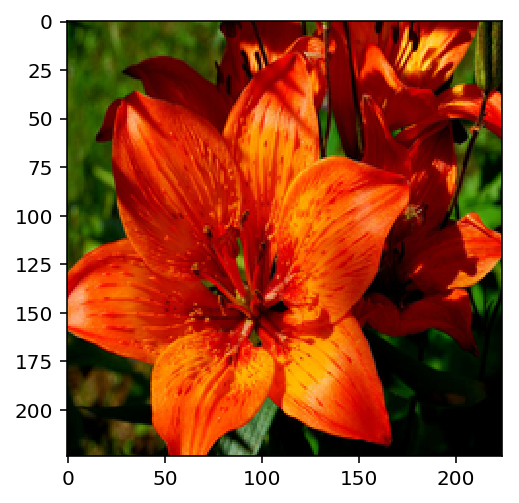

In [18]:
image = process.transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean
image = np.clip(image, 0, 1)
fig, ax = plt.subplots()
ax.imshow(image)

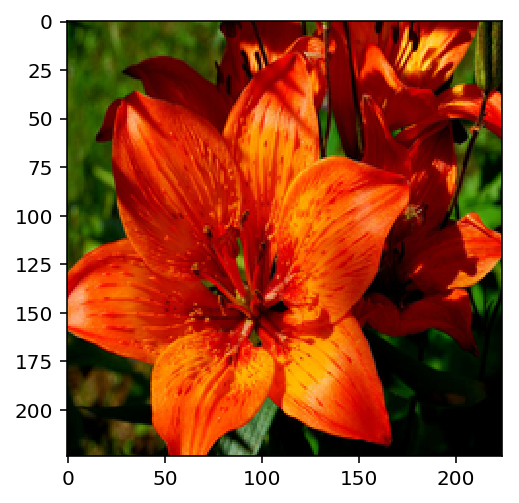

In [19]:
imshow(process)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [20]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    model.to("cpu")
    model.eval();
    output = torch.from_numpy(np.expand_dims(process_image(image_path), 
                                                  axis=0)).type(torch.FloatTensor).to("cpu")
    lnProbs = model.forward(output)
    probs = torch.exp(lnProbs)
    kProbs, kLabels = probs.topk(topk)
    kProbsArray = np.array(kProbs.detach())[0]
    kLabels= np.array(kLabels.detach())[0]
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    kLabels = [idx_to_class[label] for label in kLabels]
    kNameFlowers = [cat_to_name[label] for label in kLabels]
    
    return kProbsArray, kLabels, kNameFlowers

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [21]:
# TODO: Display an image along with the top 5 classes
%matplotlib inline

predict('fire-lilies-marilynne-bull.jpg', model, topk=5)


(array([29253484.  ,  1080589.  ,   162870.31,   148142.6 ,    38527.07],
       dtype=float32),
 ['18', '56', '46', '58', '90'],
 ['peruvian lily',
  'bishop of llandaff',
  'wallflower',
  'geranium',
  'canna lily'])

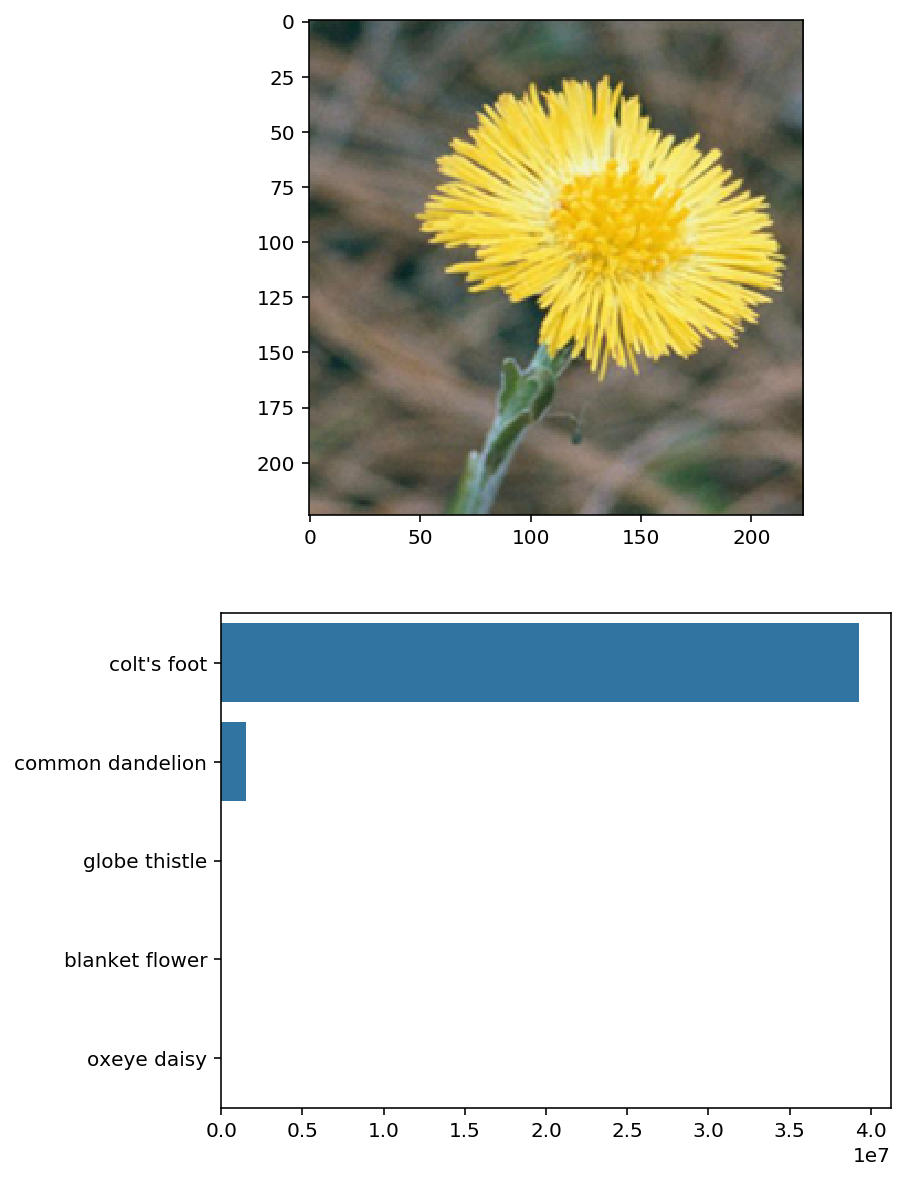

In [22]:
# https://github.com/chauhan-nitin/Udacity-ImageClassifier/blob/master/Image%20Classifier%20Project.ipynb
image_path = "flower_data/valid/12/image_04013.jpg"

# Set up plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# Set up title
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]
flower_num

# Plot flower
import seaborn as sns
img = process_image(image_path)
imshow(img, ax, title = title_);

# Make prediction
probs, labs, flowers = predict(image_path, model)

# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()

In [ ]:
# https://towardsdatascience.com/load-that-checkpoint-51142d44fb5d
Instrucciones para cargar e